# Kanye vs Kantye


In this notebook I will train mulitple classifiers for discrimination between Kanye West and Kantye West - a Twitter profile which is mocking Kanye's one by twitting philosophically inspired twitts. Let's start from training data:

In [1]:
import json


with open('kanyewest.json', 'r') as json_handle:
    kw_json = json.load(json_handle)
    
with open('kantye_west.json', 'r') as json_handle:
    ktw_json = json.load(json_handle)

Now we will perform a _train-test-valid_ split. Our experiments setup will be the following:
1. We will perform cross-validation grid search of multiple kinds of models.
2. We will choose the best one on a validation set.
3. We will perform the final evaluation on a test set.

I decided to choose `accuracy` as a main evaluation metric as the dataset is fairly balanced. I decided to use `0` label for Kanye West and `1` label for Kantye.

Below I implemented a class for datasets experiment:

In [2]:
import cached_property
from sklearn import model_selection


RANDOM_SEED = 42
TRAIN_PERCENTAGE = 0.6
TEST_PERCENTAGE = 0.2
VALID_PERCENTAGE = 0.2


full_jsons = kw_json + ktw_json
full_labels = [0] * len(kw_json) + [1] * len(ktw_json)

full_jsons = full_jsons
full_labels = full_labels


class Dataset:
    
    def __init__(
        self,
        train_jsons,
        train_labels,
        test_jsons,
        test_labels,
        valid_jsons,
        valid_labels,
    ):
        self.train_jsons = train_jsons
        self.train_labels = train_labels
        self.test_jsons = test_jsons
        self.test_labels = test_labels
        self.valid_jsons = valid_jsons
        self.valid_labels = valid_labels
    
    @staticmethod
    def get_texts_from_json(json_):
        return [twitt_json['text'] for twitt_json in json_]
        
    @cached_property.cached_property
    def train_texts(self):
        return self.get_texts_from_json(self.train_jsons)
    
    @cached_property.cached_property
    def test_texts(self):
        return self.get_texts_from_json(self.test_jsons)
    
    @cached_property.cached_property
    def valid_texts(self):
        return self.get_texts_from_json(self.valid_jsons)
        
    @classmethod
    def from_jsons_and_labels(
        cls,
        jsons,
        labels,
        train_percentage=TRAIN_PERCENTAGE,
        test_percentage=TEST_PERCENTAGE, 
        valid_percentage=VALID_PERCENTAGE,
    ):
        train_jsons, rest_jsons, train_labels, rest_labels = model_selection.train_test_split(
            jsons, labels,
            train_size=TRAIN_PERCENTAGE,
            random_state=RANDOM_SEED,
        )
        test_jsons, valid_jsons, test_labels, valid_labels = model_selection.train_test_split(
            jsons, labels,
            train_size=TEST_PERCENTAGE / (TEST_PERCENTAGE + VALID_PERCENTAGE),
            random_state=RANDOM_SEED,
        )
        return cls(
            train_jsons=train_jsons,
            train_labels=train_labels,
            test_jsons=test_jsons,
            test_labels=test_labels,
            valid_jsons=valid_jsons,
            valid_labels=valid_labels,
        )
    

dataset = Dataset.from_jsons_and_labels(
    jsons=full_jsons,
    labels=full_labels,
)

/home/marcin-mozejko/PycharmProjects/Cramer-Wold/venv/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Let's prepare preprocessing pipeline. During the data look up performed on a train set I noticed the following style characteristics which might be useful to our models:

- Kanye often use a single word tweets. This is not the case for Kantye who writes more sophisticated twitts,
- Kanye often posts links to other websites,
- Mentions might be useful,
- As Kantye mocks Kanye using Kant references - a rare words connected to Immanuel Kant might be useful,
- I am not removing the punctuation - as it turned out that it has discriminative power for this task.

I added extraction of features based on these observations to a `Preprocessor`:

In [3]:
from sklearn import base


class TwitterPreprocessor(base.BaseEstimator, base.TransformerMixin):
    
    KANT_STEMS = ['königsberg', 'deontolog', ]
    
    SINGLE_WORD_TOKEN = 'single_word_token'
    URL_TOKEN = 'url_token'
    KANT_TOKEN = 'kant_token'
    MENTION_TOKEN = 'mention_token'
    
    def __init__(
        self,
        check_if_only_single_word=True,
        replace_urls=True,
        replace_mentions=True,
        specific_stems=None,
    ):
        self.check_if_only_single_word = check_if_only_single_word
        self.replace_urls = replace_urls
        self.replace_mentions = replace_mentions
        self.specific_stems = specific_stems 
    
    def fit(self, X, y=None):
        return self
    
    def transform_single_text(self, text):
        text = text.replace('\n', ' ') # Sometimes there is \n instead of spaces
        if self.check_if_only_single_word:
            if self.check_if_single_word_in_text(text):
                text = ' '.join([self.SINGLE_WORD_TOKEN, text])
        if self.replace_urls:
            text = self.replace_urls_in_text(text)
        if self.replace_mentions:
            text = self.replace_mentions_in_text(text)
        text = self.replace_specific_stems_in_text(text)
        return text.lower()
    
    def transform(self, X):
        return [
            self.transform_single_text(text) 
            for text in X
        ]
            
    @staticmethod
    def check_if_single_word_in_text(text):
        return len(text.split()) == 1
            
    @classmethod
    def replace_urls_in_text(cls, text):
        return ' '.join([
                cls.URL_TOKEN if cls.check_if_word_is_url(word) else word
                for word in text.split()
            ])
    
    @staticmethod 
    def check_if_word_is_url(word):
        return word.startswith('http')
    
    @classmethod
    def replace_mentions_in_text(cls, text):
        return ' '.join([
                cls.MENTION_TOKEN if word.startswith('@') else word
                for word in text.split()
            ])
    
    def replace_specific_stems_in_text(self, text):
        return ' '.join([
                self.KANT_TOKEN if self.is_kant_specific_word(word) else word
                for word in text.split()
            ])
    
    def is_kant_specific_word(self, word):
        for stem in self.get_specific_stems():
            if stem in word:
                return True
        else:
            return False
        
    def get_specific_stems(self):
        if self.specific_stems is not None:
            return self.specific_stems
        return self.KANT_STEMS

        
default_preprocessor_parameters = {
    'preprocessor__check_if_only_single_word': [True, False],
    'preprocessor__replace_urls': [True, False],
    'preprocessor__replace_mentions': [True, False],
    'preprocessor__specific_stems': [None, []],
}

and specific tokenizer. Additional thing is that by using [`WordNet`](https://wordnet.princeton.edu/) API I am checking if a given token refers to a Philosopher.

In [4]:
import nltk
from nltk.corpus import wordnet as wn
from nltk import stem
from sklearn.feature_extraction import stop_words as sksw


class TwitterTokenizer:
    
    PHILOSOPHER_TOKEN = 'philo_token'
    
    def __init__(
        self,
        lemmatizer=None,
        stemmer=None,
        tokenizer=None,
        stop_words=None,
    ):
        self.lemmatizer = lemmatizer if lemmatizer else stem.WordNetLemmatizer()
        self.stemmer = stemmer if stemmer else stem.snowball.EnglishStemmer()
        self.tokenizer = tokenizer if tokenizer else nltk.word_tokenize
        self.stop_words = stop_words if stop_words else sksw.ENGLISH_STOP_WORDS
    
    def __call__(self, articles):
        tokens = [
            self.lemmatizer.lemmatize(token)
            for token in self.tokenizer(articles)
        ]
        tokens = [
            self.PHILOSOPHER_TOKEN if self._is_philosopher_token(token) else token
            for token in tokens
        ]
        tokens = [
            token
            for token in tokens
            if token not in self.stop_words
        ]
        return [self.stemmer.stem(token) for token in tokens]
    
    def _is_philosopher_token(self, token):
        synsets = wn.synsets(token)
        scores = [
            self.get_synset_philosopher_similarity(synset) 
            for synset in synsets
        ]
        if len(scores) > 0:
            return max(scores) > 0.2
        else:
            return False
        
    def get_synset_philosopher_similarity(self, synset):
        score = synset.path_similarity(wn.synsets('philosopher')[0])
        if score is None:
            return 0
        else:
            return score

Now - we can build first pipeline - baseline which uses Naive Bayes model:

In [5]:
from sklearn import pipeline
from sklearn.feature_extraction import text as sktext
from sklearn import naive_bayes

nb_pipeline = pipeline.Pipeline(
    steps=(
        ('preprocessor', TwitterPreprocessor()),
        ('vectorizer', sktext.CountVectorizer(
                tokenizer=TwitterTokenizer(),
            )
        ),
        ('nb_model', naive_bayes.BernoulliNB())
    )
)

nb_parameters = {
    'nb_model__alpha': [0.1, 1, 10],
    **default_preprocessor_parameters,
}

Now - let's fit the first pipeline:

In [6]:
from sklearn import model_selection

NB_OF_FOLDS = 5

nb_cv = model_selection.GridSearchCV(
    nb_pipeline, 
    nb_parameters, 
    scoring='accuracy',
    cv=NB_OF_FOLDS,
)
nb_cv.fit(dataset.train_texts, dataset.train_labels)   

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=(('preprocessor', TwitterPreprocessor(check_if_only_single_word=True, replace_mentions=True,
          replace_urls=True, specific_stems=None)), ('vectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='co...bulary=None)), ('nb_model', BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)))),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'nb_model__alpha': [0.1, 1, 10], 'preprocessor__check_if_only_single_word': [True, False], 'preprocessor__replace_urls': [True, False], 'preprocessor__replace_mentions': [True, False], 'preprocessor__specific_stems': [None, []]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

Now - let us prepare a function for model evaluation:

Train:
Accuracy is 0.988942
Precision is 0.977199
Recall is 1.000000


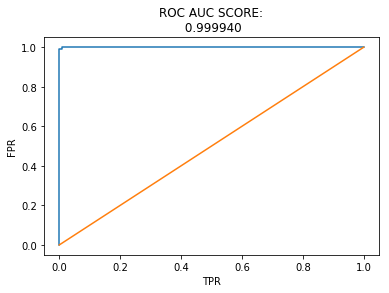

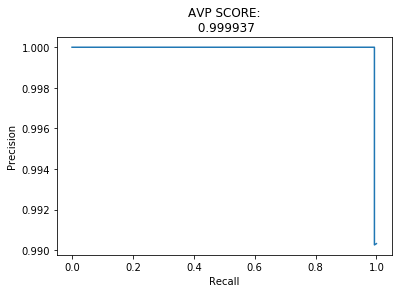

Valid:
Accuracy is 0.924242
Precision is 0.901345
Recall is 0.917808


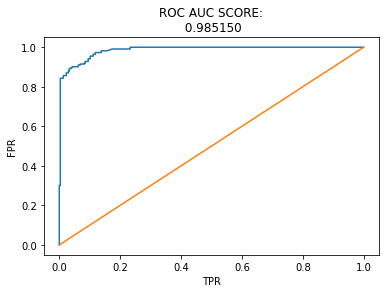

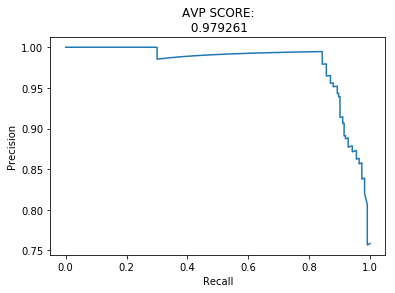

In [21]:
from sklearn import metrics
from matplotlib import pyplot as plt

%matplotlib inline

class ModelResults:
    
    def __init__(
        self,
        accuracy,
        precision,
        recall,
        auc=None,
        avp=None,
    ):
        self.accuracy = accuracy
        self.precision = precision
        self.recall = recall
        self.auc = auc
        self.avp = avp


def plot_roc_curve(labels, scores):
    tpr, fpr, _ = metrics.roc_curve(labels, scores)
    plt.plot(tpr, fpr)
    plt.xlabel('TPR')
    plt.ylabel('FPR')
    plt.plot([0, 1], [0, 1])
    auc = metrics.roc_auc_score(labels, scores)
    plt.title('ROC AUC SCORE:\n %f' % (auc))
    plt.show()
    return auc


def plot_prec_recall_curve(labels, scores):
    prec, recall, _ = metrics.precision_recall_curve(labels, scores)
    plt.plot(recall, prec)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    avp = metrics.average_precision_score(labels, scores)
    plt.title('AVP SCORE:\n %f' % (avp))
    plt.show()
    return avp


def evaluate_model(model, texts, labels, plot_auc_avp=True):
    predictions = model.predict(texts)
    
    accuracy = metrics.accuracy_score(predictions, labels)
    precision = metrics.precision_score(predictions, labels)
    recall = metrics.recall_score(predictions, labels)
    
    print('Accuracy is %f' % accuracy)
    print('Precision is %f' % precision)
    print('Recall is %f' % recall)
    
    model_results = ModelResults(
        accuracy=accuracy,
        precision=precision,
        recall=recall,
    )
    
    if plot_auc_avp:
        scores = model.predict_log_proba(texts)[: ,1]
    
        auc = plot_roc_curve(
            labels=labels,
            scores=scores,
        )
        model_results.auc = auc
        
        avp = plot_prec_recall_curve(
            labels=labels,
            scores=scores,
        )
        model_results.avp = avp
        
    return model_results

print('Train:')
evaluate_model(
    model=nb_cv,
    texts=dataset.train_texts, 
    labels=dataset.train_labels,
)
print('Valid:')
_ = evaluate_model(
    model=nb_cv,
    texts=dataset.valid_texts, 
    labels=dataset.valid_labels,
)

As we may see - even Naive Bayes model works really good for this task. Now - let us have a look at features used by the model:

In [26]:
import numpy as np


def visualize_naive_bayes_features(nb_pipeline_, nb_of_features):
    nb = nb_cv.best_estimator_.steps[2][1]
    vectorizer = nb_cv.best_estimator_.steps[1][1]
    kw_log_probs, ktw_log_probs = nb.feature_log_prob_
    best_features_indices = np.abs(
        kw_log_probs - ktw_log_probs,
    ).argsort()[-nb_of_features:]
    best_keys_and_log_probs_ = [
        (key, kw_log_probs[value], ktw_log_probs[value])
        for key, value in vectorizer.vocabulary_.items() 
        if value in best_features_indices
    ]
    for key, kw_log_prob, ktw_log_prob in best_keys_and_log_probs_:
        print('Word: %s, Kanye log proba: %f, Kantye log proba: %f' % 
             (key, kw_log_prob, ktw_log_prob))

visualize_naive_bayes_features(nb_pipeline, 20)

Word: ration, Kanye log proba: -8.090096, Kantye log proba: -2.888421
Word: limit, Kanye log proba: -8.090096, Kantye log proba: -3.519225
Word: reason, Kanye log proba: -8.090096, Kantye log proba: -2.888421
Word: man, Kanye log proba: -8.090096, Kantye log proba: -2.631921
Word: judgement, Kanye log proba: -8.090096, Kantye log proba: -3.320554
Word: empir, Kanye log proba: -8.090096, Kantye log proba: -3.414964
Word: #, Kanye log proba: -8.090096, Kantye log proba: -2.831587
Word: feel, Kanye log proba: -2.891599, Kantye log proba: -8.030084
Word: pure, Kanye log proba: -8.090096, Kantye log proba: -3.519225
Word: transcendent, Kanye log proba: -8.090096, Kantye log proba: -3.081324
Word: ;, Kanye log proba: -8.090096, Kantye log proba: -3.234294
Word: ', Kanye log proba: -8.090096, Kantye log proba: -2.504631
Word: club, Kanye log proba: -8.090096, Kantye log proba: -3.414964
Word: moral, Kanye log proba: -8.090096, Kantye log proba: -2.678226
Word: metaphys, Kanye log proba: -8.09

As we may see - model have learnt that terms connected to Kantian philosophy are important. We may also see that Kantye uses punctuation way more often.

Now - let us try Logistic Regression model:

In [10]:
from sklearn import linear_model
from sklearn import preprocessing

lr_pipeline = pipeline.Pipeline(
    steps=(
        ('preprocessor', TwitterPreprocessor()),
        ('vectorizer', sktext.CountVectorizer(
                tokenizer=TwitterTokenizer(),
            )
        ),
        ('lr_model', linear_model.LogisticRegression(random_state=RANDOM_SEED))
    )
)

lr_parameters = {
    'lr_model__C': [0.1, 1, 10],
    **default_preprocessor_parameters,
}


lr_cv = model_selection.GridSearchCV(
    lr_pipeline, 
    lr_parameters, 
    cv=NB_OF_FOLDS,
    scoring='accuracy',
)
lr_cv.fit(dataset.train_texts, dataset.train_labels)   

/home/marcin-mozejko/PycharmProjects/Cramer-Wold/venv/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=(('preprocessor', TwitterPreprocessor(check_if_only_single_word=True, replace_mentions=True,
          replace_urls=True, specific_stems=None)), ('vectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='co..., penalty='l2', random_state=42, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)))),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'lr_model__C': [0.1, 1, 10], 'preprocessor__check_if_only_single_word': [True, False], 'preprocessor__replace_urls': [True, False], 'preprocessor__replace_mentions': [True, False], 'preprocessor__specific_stems': [None, []]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

.. and evaluate it:

Train:
Accuracy is 1.000000
Precision is 1.000000
Recall is 1.000000


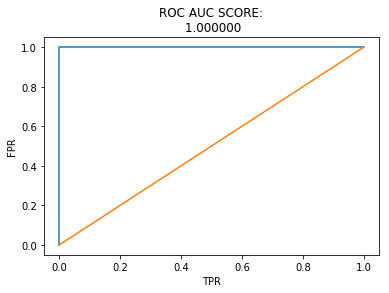

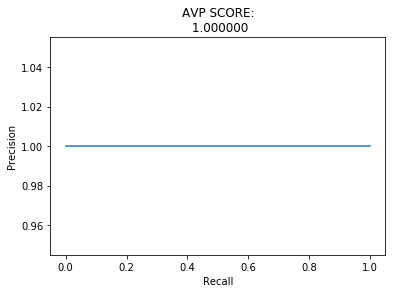

Valid:
Accuracy is 0.946970
Precision is 0.946188
Recall is 0.929515


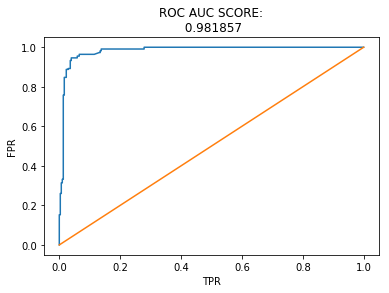

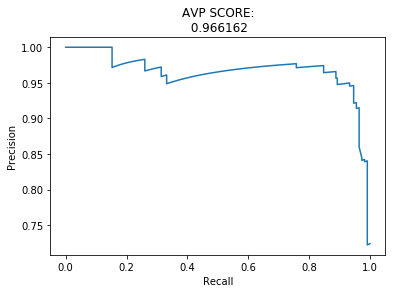

In [11]:
print('Train:')
evaluate_model(
    model=lr_cv,
    texts=dataset.train_texts, 
    labels=dataset.train_labels,
)
print('Valid:')
evaluate_model(
    model=lr_cv,
    texts=dataset.valid_texts, 
    labels=dataset.valid_labels,
)

As we may see - Logistic Regression model has better accuracy but slightly worse Average Precision.

Now let us try decision trees:

In [12]:
from sklearn import tree


dt_pipeline = pipeline.Pipeline(
    steps=(
        ('preprocessor', TwitterPreprocessor()),
        ('vectorizer', sktext.CountVectorizer(
                tokenizer=TwitterTokenizer(),
            )
        ),
        ('dt_model', tree.DecisionTreeClassifier())
    )
)

dt_parameters = {
    'dt_model__max_depth': [25, 50, 100],
    **default_preprocessor_parameters,
}


dt_cv = model_selection.GridSearchCV(
    dt_pipeline, 
    dt_parameters, 
    cv=NB_OF_FOLDS,
    scoring='accuracy',
)
dt_cv.fit(dataset.train_texts, dataset.train_labels) 

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=(('preprocessor', TwitterPreprocessor(check_if_only_single_word=True, replace_mentions=True,
          replace_urls=True, specific_stems=None)), ('vectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='co...      min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')))),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'dt_model__max_depth': [25, 50, 100], 'preprocessor__check_if_only_single_word': [True, False], 'preprocessor__replace_urls': [True, False], 'preprocessor__replace_mentions': [True, False], 'preprocessor__specific_stems': [None, []]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [13]:
print('Train:')
evaluate_model(
    model=dt_cv,
    texts=dataset.train_texts, 
    labels=dataset.train_labels,
    plot_auc_avp=False,
)
print('Valid:')
_ = evaluate_model(
    model=dt_cv,
    texts=dataset.valid_texts, 
    labels=dataset.valid_labels,
    plot_auc_avp=False,
)

Train:
Accuracy is 1.000000
Precision is 1.000000
Recall is 1.000000
Valid:
Accuracy is 0.935606
Precision is 0.923767
Recall is 0.923767


In this case - I have not plotted precision recall and ROC curves as trees offer only prediction. As we may see - results are better than Naive Bayes but worse than logistic regression.

In [14]:
from sklearn import ensemble 


rf_pipeline = pipeline.Pipeline(
    steps=(
        ('preprocessor', TwitterPreprocessor()),
        ('vectorizer', sktext.CountVectorizer(
                tokenizer=TwitterTokenizer(),
            )
        ),
        ('rf_model', ensemble.RandomForestClassifier())
    )
)

rf_parameters = {
    'rf_model__n_estimators': [5, 10, 20, 50],
    'rf_model__max_depth': [5, 10, 20],
    **default_preprocessor_parameters,
}


rf_cv = model_selection.GridSearchCV(
    rf_pipeline, 
    rf_parameters, 
    cv=NB_OF_FOLDS,
    scoring='accuracy',
)
rf_cv.fit(dataset.train_texts, dataset.train_labels) 

/home/marcin-mozejko/PycharmProjects/Cramer-Wold/venv/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=(('preprocessor', TwitterPreprocessor(check_if_only_single_word=True, replace_mentions=True,
          replace_urls=True, specific_stems=None)), ('vectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='co...obs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)))),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'rf_model__n_estimators': [5, 10, 20, 50], 'rf_model__max_depth': [5, 10, 20], 'preprocessor__check_if_only_single_word': [True, False], 'preprocessor__replace_urls': [True, False], 'preprocessor__replace_mentions': [True, False], 'preprocessor__specific_stems': [None, []]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

Train:
Accuracy is 0.974724
Precision is 0.954397
Recall is 0.993220


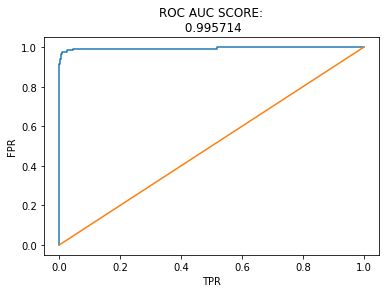

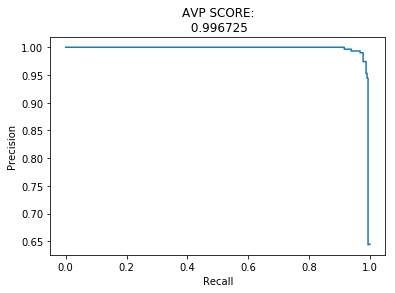

Valid:
Accuracy is 0.928030
Precision is 0.905830
Recall is 0.922374


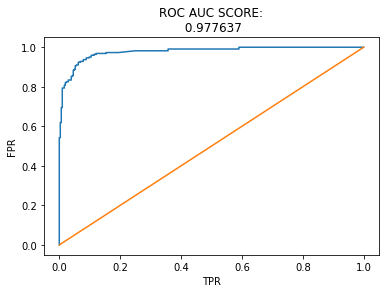

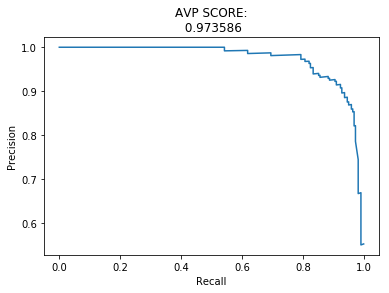

In [15]:
print('Train:')
evaluate_model(
    model=rf_cv,
    texts=dataset.train_texts, 
    labels=dataset.train_labels,
)
print('Valid:')
_ = evaluate_model(
    model=rf_cv,
    texts=dataset.valid_texts, 
    labels=dataset.valid_labels,
)

Once again - random forrest is worse than logistic regression.

As we may see - the logistic regression provides the best results on validation set. Let us analyze errors of this model:

In [16]:
lr_predictions = lr_cv.predict(dataset.valid_texts)
wrongly_predicted = np.array(dataset.valid_labels) != lr_predictions
scores = lr_cv.predict_proba(dataset.valid_texts)[:, 1]


for text, true_label, score, wrongly_predicted_flag in zip(
    dataset.valid_texts,
    dataset.valid_labels,
    scores,
    wrongly_predicted): 
    if not wrongly_predicted_flag:
        continue
    print('True label: %d, Score: %f, Text: %s' % (true_label, score, text))

True label: 1, Score: 0.214723, Text: If they hate then let them hate and watch a flawed sense of moral duty pile up.
True label: 0, Score: 0.998629, Text: I am currently the single highest paid person in footwear. That means I make more money on shoes than Michael Jordan.
True label: 0, Score: 0.523432, Text: it's not where you take things from.  It's where you take them to
True label: 0, Score: 0.896705, Text: that's the last tweet of the day. I did that one for my god-brother Puff.  Now ima go watch the Cavs.
True label: 1, Score: 0.207961, Text: 10 years later I'm still the same kid from Chicago. Still dreamin out loud. Still banging on the door. Still toppling man-made falsehoods
True label: 0, Score: 0.502191, Text: yes I got rid of my last lawyer why? Because he wouldn't come to work full time. I also asked my last manager to co… https://t.co/cf3z7aEmXa
True label: 1, Score: 0.193878, Text: Looks like I need to up my game. https://t.co/G7z3d7MJ7V
True label: 1, Score: 0.035330, 

As we may see some of thess examples are really tricky. E.g.:

- Donald Glover is a free thinker
- it's not where you take things from.  It's where you take them to
- the beauty is in the imperfection(s)
- we have freedom of speech but not freedom of thought
- 10 years later I'm still the same kid from Chicago. Still dreamin out loud. Still banging on the door. Still toppling man-made falsehoods

Some need a model which truely understand the subtelty of philosophy like:

- To be is to beast

Obviously - some seems to be easy, like:

- I am currently the single highest paid person in footwear. That means I make more money on shoes than Michael Jordan.

We can also look up the weights of the model to check whether it captured appropriate paterns:

In [17]:
def visualize_logistic_regression_features(lr_cv_, nb_of_features):
    lr = lr_cv_.best_estimator_.steps[2][1]
    vectorizer = lr_cv_.best_estimator_.steps[1][1]
    weights = lr.coef_.flatten()
    best_features_indices = np.abs(
        weights,
    ).argsort()[-nb_of_features:]
    best_keys_and_weights = [
        (key, weights[value])
        for key, value in vectorizer.vocabulary_.items() 
        if value in best_features_indices
    ]
    for key, weight in best_keys_and_weights:
        print('Word: %s, weight: %f.' % (key, weight))
    

visualize_logistic_regression_features(lr_cv_=lr_cv, nb_of_features=20)

Word: ration, weight: 1.849667.
Word: url_token, weight: -2.914423.
Word: ,, weight: 2.892944.
Word: man, weight: 1.718940.
Word: ?, weight: 3.408707.
Word: free, weight: -1.754670.
Word: philo_token, weight: 2.887961.
Word: #, weight: 2.359834.
Word: @, weight: 2.158237.
Word: love, weight: -2.992656.
Word: look, weight: 1.863706.
Word: fear, weight: -1.817813.
Word: peopl, weight: -1.813266.
Word: !, weight: 1.741406.
Word: content, weight: 2.330850.
Word: cogito, weight: 1.709730.
Word: coco, weight: 1.709730.
Word: kantye2020, weight: 1.871594.
Word: 🤯, weight: 5.141270.
Word: bieber, weight: 2.346803.


As we may see - features seem to be reasonable. It is good to see that additional tokens provided by custom preprocessors and tokenizers like `url_token` or `philo_token` were placed among features with the greatest weights.

Now - let us have a look if our model does not suffer from overconfidence:

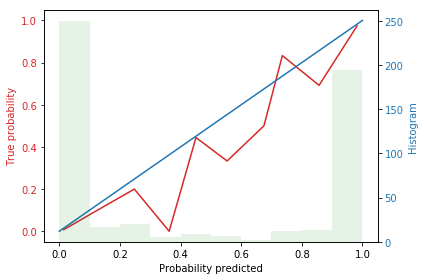

In [37]:
from sklearn import calibration


def plot_calibration_curve(model, texts, labels, bins=10):
    scores = model.predict_proba(texts)[:, 1]
    prob_true, prob_pred = calibration.calibration_curve(
        y_true=labels,
        y_prob=scores,
        n_bins=bins,
    )
    fig, ax1 = plt.subplots()

    color = 'tab:red'
    ax1.set_xlabel('Probability predicted')
    ax1.set_ylabel('True probability', color=color)
    ax1.plot(prob_pred, prob_true, color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.plot([0, 1], [0, 1])

    ax2 = ax1.twinx()

    color = 'tab:blue'
    ax2.set_ylabel('Histogram', color=color)
    ax2.hist(scores, bins=bins, color='g', alpha=0.1)
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()
    plt.show()
    

plot_calibration_curve(lr_cv, dataset.valid_texts, dataset.valid_labels)

As we may see - linear regression model is fairly callibrated (not suprisingly) - especially for cases where score are close to $0$ or $1$. For score between $(0.2, 0.8)$ scores suffer from slight miscalibration but only few cases fall into this region.

Now - we can test our model on a final hold-out set:

Test:
Accuracy is 1.000000
Precision is 1.000000
Recall is 1.000000


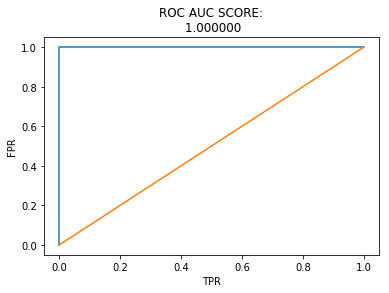

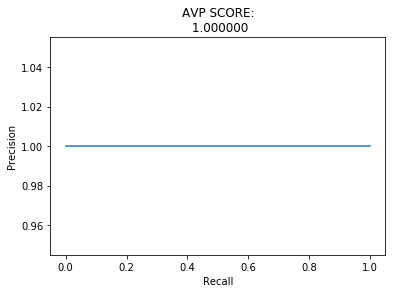

In [18]:
print('Test:')
evaluate_model(
    model=lr_cv,
    texts=dataset.test_texts, 
    labels=dataset.test_labels,
)

As we may see - a classical Logistic Regression with a task specific preprocessing achieved 100% accuracy on the test set. 

### Final remarks:

1. I have decided not to use _deep learning_ algorithms. It is mostly due to the fact that:
    - task is pretty subtle - from my experience, _deep learning_ might overfit in this case,
    - for a text classification it is rare (although I have experienced such phenomenon) for _deep learning_ to be better than classical model by a substantial matter,
    - I found understandability of a model important and go with _deep learning_ algorithms only when they can provide a substantial improvement.

2. Although the model achieved a perfect accuracy on a test set - I would mention that it had imperfect classification during a training process. 100% might come from _sampling bias_.


### Summary of what I have done:

1. I fixed the `RANDOM_SEED`, splitted dataset and manually reviewed the test set in order to find interesting patterns and understand the data. From this I got insights like e.g. philosophical terms, philosopher occurences, URLs, etc.
2. I prepared and implemented all classes and models needed for performing prediction.
3. I chose the model with the best accuracy and analyzed its errors and overconfidence.
4. I inspected the model parameters to gain interesting insights.

### Further steps:

One can try to improve models by:
- adding more _Kantye specific_ words,
- using other kinds of Tokenizers (e.g. tf-idf),
- getting more data :)

### Extensions:

In case of training models to classify Kanye / Kantye / Rest I would use a publicly available dataset of tweets and add it to our training data as `No-Kanye-Kantye` class. Although there is a possibility that within this dataset there will be twitts of either Kanye or Kantye - but one can tackle that using a technique called [positive unlabelled learning](https://arxiv.org/pdf/1608.06807.pdf).